In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor as RFR

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.layers import LeakyReLU, ReLU
from keras.regularizers import l1, l2, l1_l2

In [ ]:
data = pd.read_csv('drive/MyDrive/DATA 310/Projects/AirI.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,3.4482,0.001314,0.15747,0.688300,0.152920,0.00000,0.00000,0.096603,0.52135,0.38205,...,-2.94590,0.219960,-0.69045,0.24044,-0.258640,1.33870,0.114820,-0.43046,0.82309,1.54350
1,3.3019,0.188490,0.55319,0.258290,0.000031,0.00000,0.00000,0.039008,0.43211,0.52716,...,-0.22680,-0.428570,0.74992,-0.11192,1.583000,0.88565,-0.053227,0.67796,-1.72010,-0.55051
2,2.2894,0.052169,0.43852,0.494030,0.015282,0.00000,0.00000,0.000000,0.00000,0.39484,...,1.15790,0.010118,0.73593,1.35600,0.057821,-1.44140,1.581800,1.25420,1.02540,-1.01890
3,2.6207,0.000000,0.00000,0.004213,0.109340,0.49344,0.39300,0.000000,0.00000,0.57854,...,-0.69767,1.577800,0.54899,-0.78042,1.136700,-0.84240,0.993120,-0.44576,-0.78778,-1.49090
4,2.8439,0.000000,0.00000,0.019504,0.260470,0.54986,0.17016,0.010568,0.30520,0.67046,...,-1.49170,-0.688640,-0.69924,0.36074,-0.685860,-0.76161,-0.354560,0.83093,-0.27100,0.38861


In [ ]:
Xf = data.values
x = Xf[:, 1:]
y = Xf[:, 0]

1. Implement a neural network model for regression in the case of the air quality dataset (AirI.csv). As before, the dependent variable y is the first column, and the input variables are the rest of the columns. Consider measuring the external validity from a 5-fold cross-validation; in this exercise, you would have to implement your design of the neural network that includes experimentation with the number of layers, neurons per layer, choice of activation functions, kernel regularizations, etc. As guidance, you would know that your model is doing reasonably well if the external validity (average MSE on the test sets) is less than 0.29.
 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
scale = SS()

In [ ]:
PE = []

for idxtrain, idxtest in kf.split(x):
  # subset and scale data
  xtrain = scale.fit_transform(x[idxtrain])
  xtest = scale.transform(x[idxtest])
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  
  # build model
  model = Sequential()
  model.add(Dense(x.shape[1], activation=LeakyReLU(0.1), kernel_regularizer=l2(0.001), use_bias=True,input_dim=x.shape[1]))
  model.add(Dense(x.shape[1], activation=LeakyReLU(0.01), kernel_regularizer=l2(0.001), use_bias=True))
  # output layer with 1 neuron b/c we're solve a regression problem
  model.add(Dense(1,activation='linear'))
  opt = Adam(learning_rate=0.001)
  model.compile(loss='mse',optimizer=opt)
  model.fit(xtrain,ytrain,epochs=1000,verbose=0, batch_size=np.floor(xtrain.shape[0]/16).astype(int))
  mse_test = mse(ytest, model.predict(xtest))
  print(mse_test)
  PE.append(mse_test)
print('The External Validation of the Neural Network model is : ' + str(np.mean(PE)))


1/1 [==============================] - 0s 43ms/step
0.22024565361677761
1/1 [==============================] - 0s 42ms/step
0.21454905214509587
1/1 [==============================] - 0s 44ms/step
0.24075180483244554
1/1 [==============================] - 0s 41ms/step
0.5029715741279875
1/1 [==============================] - 0s 42ms/step
0.2137812783584063
The External Validation of the Neural Network model is : 0.2784598726161426


---
2. Based on the class examples, design and implement a convolutional neural network model for classification in the case of the MNIST dataset and measure the validity in the test sets. The average accuracy on the test sets is expected to be at least 99%.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator # to create realistic geometrical deformations of the images
from tensorflow.keras.utils import to_categorical # this does the same as OneHotEncoder
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
from tensorflow.python.framework import ops

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()

In [ ]:
def load_dataset():
	(trainX, trainY), (testX, testY) = mnist.load_data()
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm

def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(200))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(10, activation='softmax'))
  opt = Adam(learning_rate=0.002)
  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1234)
	for train_ix, test_ix in kfold.split(dataX,trainy):
		model = define_model()
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		history = model.fit(trainX, trainY, epochs=25, batch_size=150, validation_data=(testX, testY), verbose=0)
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		scores.append(acc)
		histories.append(history)
	return scores, histories, model
 
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=3.0)
	plt.show()
 
def summarize_performance(scores):
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	plt.boxplot(scores)
	plt.show()
 
def run_everything():
	vals= []
	trainX, trainY, testX, testY = load_dataset()
	trainX, testX = prep_pixels(trainX, testX)
	scores, histories, model = evaluate_model(trainX, trainY)
	vals.append(scores)
	summarize_diagnostics(histories)
	summarize_performance(scores)
	print('The overall accuracy is :'+str(np.mean(vals)))
	return model

> 99.058
> 98.950
> 99.042
> 99.175
> 99.058


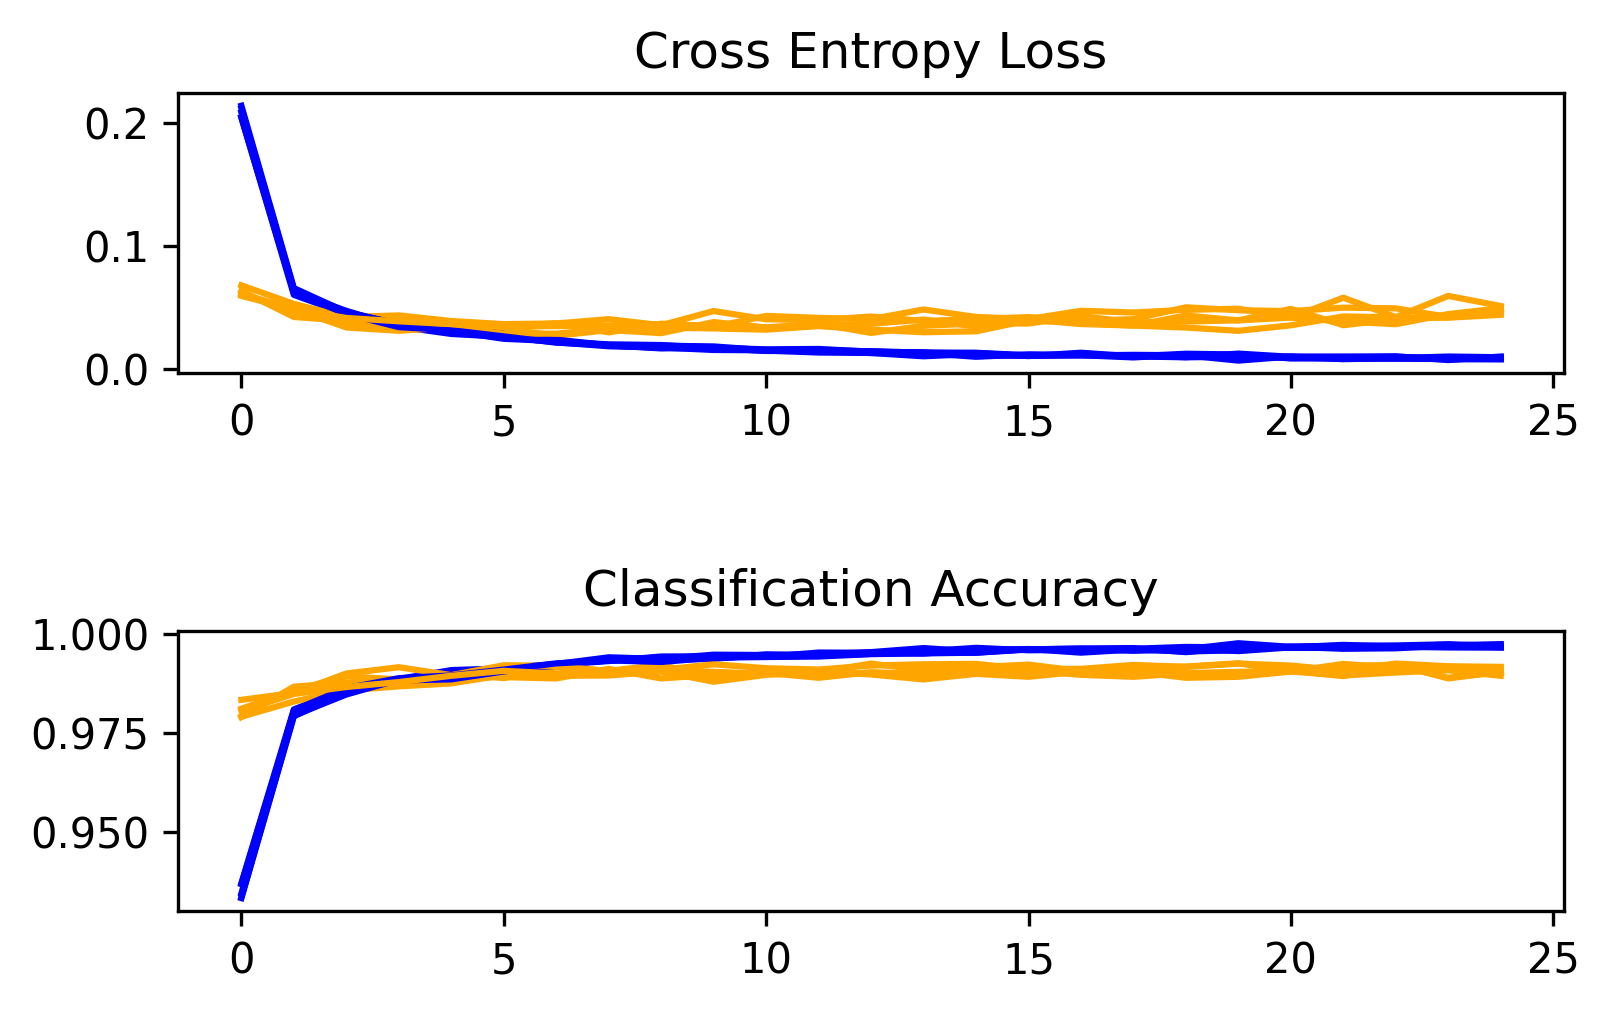

Accuracy: mean=99.057 std=0.072, n=5


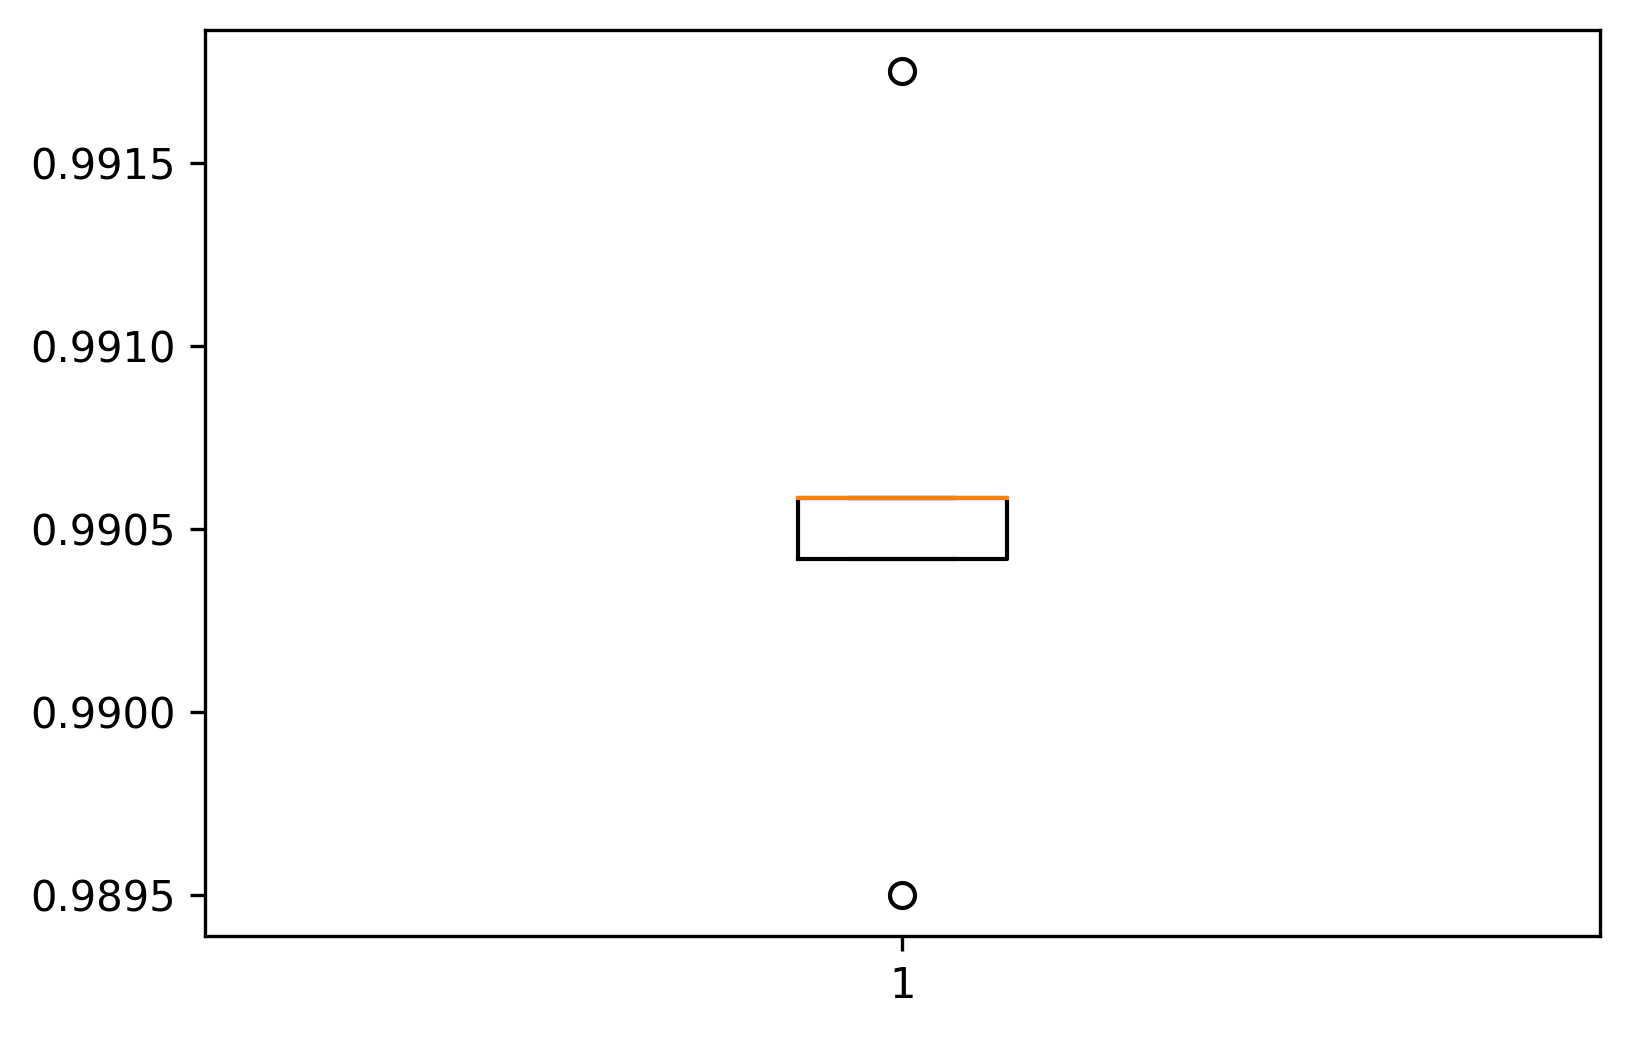

The overall accuracy is :0.9905666708946228


In [ ]:
model = run_everything()